In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import pickle
import joblib
from itertools import product
from joblib import Parallel, delayed
import optuna
import json

/Users/danielzellner/Documents/Studium/Bachelorthesis/venv_global/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prophet

In [9]:
df_neutor = pd.read_pickle('df_neutor_features.pkl')
df_neutor

,Datum,Zeit,Wochentag,Neutor (gesamt),Feiertag,Semesterferien,Ferien,Lockdown,Verkehr_vor_einer_Woche,Verkehrs_Differenz,Neutor_FR_stadtauswärts_vor_einer_Woche,Neutor_FR_stadteinwärts_vor_einer_Woche,Neutor_FR_stadtauswärts_Differenz,Neutor_FR_stadteinwärts_Differenz,Top4_letzte_Woche,Berufsverkehr,Jahreszeit
0,2018-01-01,00:00:00,Montag,71.0,1,1,1,0,71.0,0.0,45.0,26.0,0.0,0.0,False,False,Winter
1,2018-01-01,01:00:00,Montag,67.0,1,1,1,0,67.0,0.0,32.0,35.0,0.0,0.0,False,False,Winter
2,2018-01-01,02:00:00,Montag,123.0,1,1,1,0,123.0,0.0,70.0,53.0,0.0,0.0,False,False,Winter
3,2018-01-01,03:00:00,Montag,171.0,1,1,1,0,171.0,0.0,107.0,64.0,0.0,0.0,False,False,Winter
4,2018-01-01,04:00:00,Montag,102.0,1,1,1,0,102.0,0.0,76.0,26.0,0.0,0.0,False,False,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43816,2022-12-31,18:00:00,Samstag,365.0,0,1,1,0,100.0,265.0,69.0,31.0,123.0,142.0,False,True,Winter
43817,2022-12-31,19:00:00,Samstag,303.0,0,1,1,0,61.0,242.0,37.0,24.0,102.0,140.0,False,False,Winter
43818,2022-12-31,20:00:00,Samstag,207.0,0,1,1,0,43.0,164.0,18.0,25.0,87.0,77.0,False,False,Winter
43819,2022-12-31,21:00:00,Samstag,149.0,0,1,1,0,36.0,113.0,17.0,19.0,49.0,64.0,False,False,Winter


In [11]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

df_neutor['Datum'] = pd.to_datetime(df_neutor['Datum'])

# Konvertieren der 'Zeit'-Spalte in Stunden
df_neutor['Zeit'] = pd.to_datetime(df_neutor['Zeit'], format='%H:%M:%S').dt.time
df_neutor['Stunden'] = df_neutor['Zeit'].apply(lambda x: x.hour + x.minute / 60)

features = ['Wochentag', 'Jahreszeit', 'Feiertag', 'Semesterferien', 'Ferien', 'Lockdown', 
            'Verkehr_vor_einer_Woche', 'Verkehrs_Differenz',
            'Neutor_FR_stadtauswärts_vor_einer_Woche', 'Neutor_FR_stadteinwärts_vor_einer_Woche',
            'Neutor_FR_stadtauswärts_Differenz', 'Neutor_FR_stadteinwärts_Differenz',
            'Top4_letzte_Woche', 'Berufsverkehr', 'Stunden']

df_prophet = df_neutor[['Datum', 'Neutor (gesamt)'] + features].rename(columns={"Datum": "ds", "Neutor (gesamt)": "y"})

# Kategoriale Spalten
categorical_columns = ['Wochentag', 'Jahreszeit', 'Top4_letzte_Woche', 'Berufsverkehr']

# Erstellen OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Gesamtdatenmenge
data_size = len(df_neutor)

# Aufteilung in Trainings-, Validierungs- und Testsets
train_size = int(data_size * 0.7)  # 70% Training
test_size = int(data_size * 0.2)   # 20% Test
val_size = data_size - train_size - test_size  # Rest für die Validierung

# Aufteilen der Daten in Trainings- und Testdaten
train_prophet = df_prophet.iloc[:train_size]
val_prophet = df_prophet.iloc[train_size:train_size+val_size]
test_prophet = df_prophet.iloc[train_size+val_size:]

# Erstellen der kodierten Daten für train_prophet, val_prophet und test_prophet
encoded_train = encoder.fit_transform(train_prophet[categorical_columns])
encoded_val = encoder.transform(val_prophet[categorical_columns])
encoded_test = encoder.transform(test_prophet[categorical_columns])

encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Hinzufügen der kodierten Spalten zu den DataFrames
train_prophet = train_prophet.join(pd.DataFrame(encoded_train.toarray(), columns=encoded_columns, index=train_prophet.index))
val_prophet = val_prophet.join(pd.DataFrame(encoded_val.toarray(), columns=encoded_columns, index=val_prophet.index))
test_prophet = test_prophet.join(pd.DataFrame(encoded_test.toarray(), columns=encoded_columns, index=test_prophet.index))

# Aktualisieren Sie die Liste der zusätzlichen Regressoren
additional_regressors = ['Feiertag', 'Semesterferien', 'Ferien', 'Lockdown', 'Verkehr_vor_einer_Woche',
                         'Verkehrs_Differenz', 'Neutor_FR_stadtauswärts_vor_einer_Woche', 'Neutor_FR_stadteinwärts_vor_einer_Woche',
                         'Neutor_FR_stadtauswärts_Differenz', 'Neutor_FR_stadteinwärts_Differenz', 'Top4_letzte_Woche', 'Berufsverkehr', 'Stunden']
additional_regressors += list(encoded_columns)

holidays = pd.DataFrame({
  'holiday': 'covid_effect',
  'ds': pd.to_datetime(['2020-03-22', '2021-12-31']),
  'lower_window': 0,  
  'upper_window': 707, 
})

In [31]:
# Hyperparameter Optuna
def objective(trial):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10.0)
    changepoint_range = trial.suggest_float('changepoint_range', 0.7, 0.95)
    n_changepoints = trial.suggest_int('n_changepoints', 10, 40)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    growth = trial.suggest_categorical('growth', ['linear', 'logistic'])

    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        changepoint_range=changepoint_range,
        n_changepoints=n_changepoints,
        seasonality_mode=seasonality_mode,
        growth=growth,
        daily_seasonality=True,
        holidays=holidays
    )
    
    # Hinzufügen der zusätzlichen Regressoren und anderer Anpassungen
    for regressor in additional_regressors:
        model.add_regressor(regressor)
    
    if growth == 'logistic':
        train_prophet['cap'] = 1.5 * train_prophet['y'].max()
        train_prophet['floor'] = 0
        val_prophet['cap'] = 1.5 * train_prophet['y'].max()
        val_prophet['floor'] = 0
    
    model.fit(train_prophet)
    
    forecast = model.predict(val_prophet)
    
    y_true = val_prophet['y'].values
    y_pred = forecast['yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    
    return mae

pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=40, timeout=7200) 

# Ergebnisse
best_params = study.best_params
best_score = study.best_value
results_df = pd.DataFrame([best_params])
results_df['MAE'] = best_score

[I 2023-09-01 11:29:26,638] A new study created in memory with name: no-name-1314f069-a2cb-4b2d-a814-bffa89e29379
11:29:50 - cmdstanpy - INFO - Chain [1] start processing
11:33:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-09-01 11:33:11,879] Trial 0 finished with value: 210.22672526848194 and parameters: {'changepoint_prior_scale': 0.26175714408633743, 'seasonality_prior_scale': 7.492841159430817, 'holidays_prior_scale': 8.589659640513712, 'changepoint_range': 0.8865807383468445, 'n_changepoints': 38, 'seasonality_mode': 'additive', 'growth': 'linear'}. Best is trial 0 with value: 210.22672526848194.
11:33:32 - cmdstanpy - INFO - Chain [1] start processing
11:36:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-09-01 11:36:51,265] Trial 1 finished with value: 210.23895237049192 and parameters: {'changepoint_prior_scale': 0.16554703338408103, 'seasonality_prior_scale': 7.250906419800041, 'holidays_prior_scale': 7.262313297504587, 'changepoint_range': 0.9490356295213

In [32]:
best_params

{'changepoint_prior_scale': 0.48634208506020515,
 'seasonality_prior_scale': 8.254693465955198,
 'holidays_prior_scale': 5.062751910585831,
 'changepoint_range': 0.7951592508527702,
 'n_changepoints': 13,
 'seasonality_mode': 'additive',
 'growth': 'logistic'}

In [33]:
joblib.dump(encoder, 'model_metadata/encoder_prophet.pkl')

['model_metadata/encoder_prophet.pkl']

In [36]:
# Trainieren des Modells mit den besten Hyperparametern
best_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    changepoint_range=best_params['changepoint_range'],
    n_changepoints=best_params['n_changepoints'],
    seasonality_mode=best_params['seasonality_mode'],
    growth=best_params['growth'],
    daily_seasonality=True,
    holidays=holidays
)

for regressor in additional_regressors:
    best_model.add_regressor(regressor)

if best_params['growth'] == 'logistic':
    train_prophet['cap'] = 1.5 * train_prophet['y'].max()
    train_prophet['floor'] = 0
    val_prophet['cap'] = 1.5 * train_prophet['y'].max()
    val_prophet['floor'] = 0

best_model.fit(train_prophet)

# Vorhersagen für Trainings- und Validierungssets
forecast_train = best_model.predict(train_prophet)
forecast_val = best_model.predict(val_prophet)

# Fehler berechnen
mae_train = mean_absolute_error(train_prophet['y'].values, forecast_train['yhat'].values)
mae_val = mean_absolute_error(val_prophet['y'].values, forecast_val['yhat'].values)

print(f"Training MAE: {mae_train}")
print(f"Validation MAE: {mae_val}")

14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:17:37 - cmdstanpy - INFO - Chain [1] done processing


Training MAE: 394.85716256536136
Validation MAE: 210.1432138736533


In [6]:
train_prophet.to_pickle("model_metadata/train_prophet.pkl")

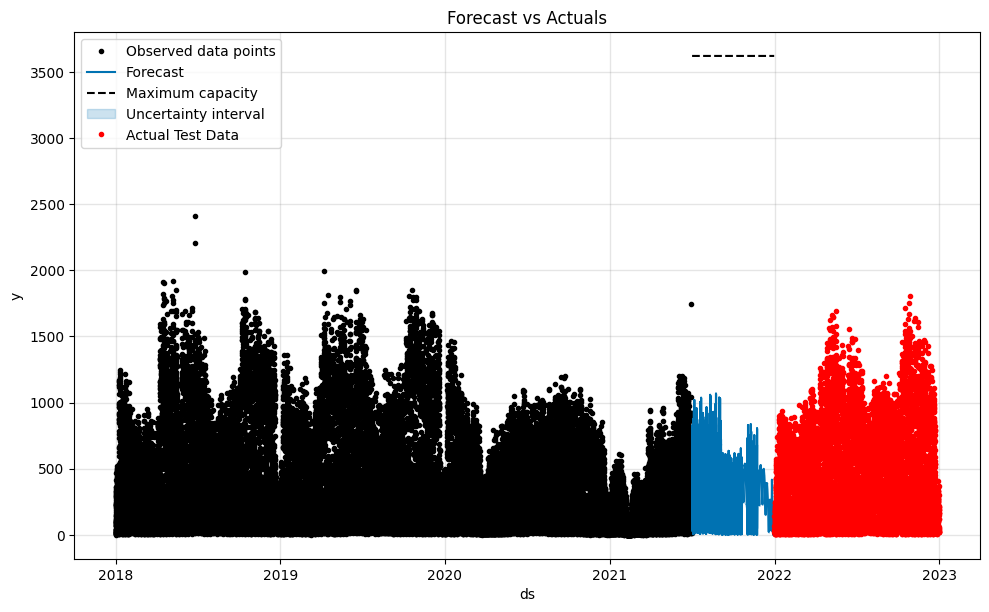

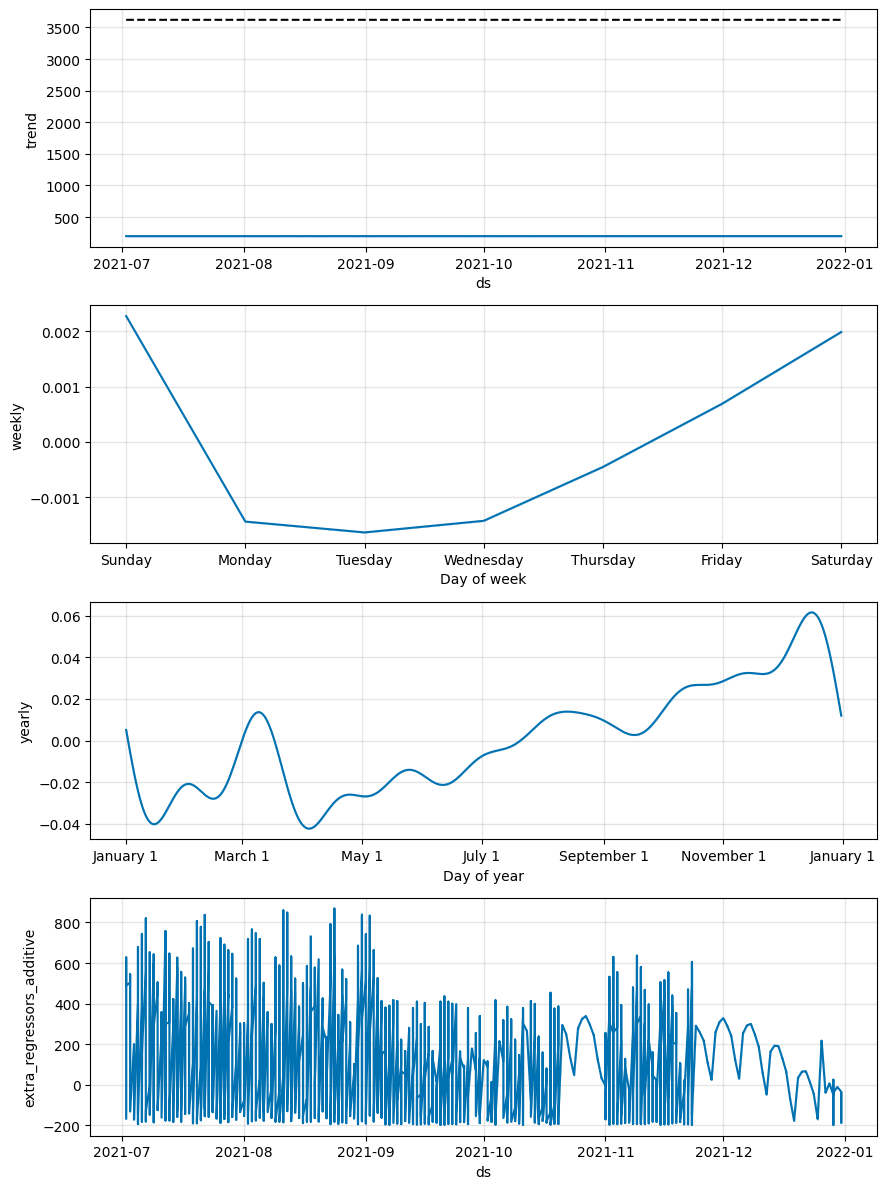

In [37]:
# Prophet-Standardplot
fig = best_model.plot(forecast)
ax = fig.gca()

# Testdaten zum Plot hinzufügen
ax.plot(test_prophet['ds'], test_prophet['y'], 'r.', label='Actual Test Data')
ax.legend()

plt.title('Forecast vs Actuals')
plt.show()

# Plot der Vorhersagekomponenten
fig_components = best_model.plot_components(forecast)
plt.show()

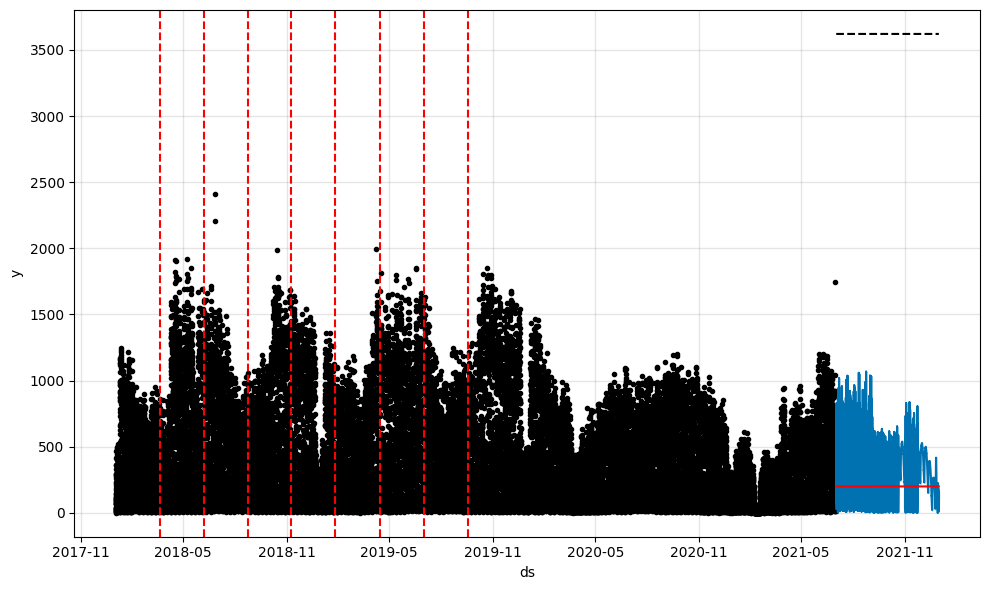

In [42]:
from prophet.plot import add_changepoints_to_plot
fig = best_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), best_model, forecast)

In [50]:
with open('prophet_model_without_weather.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [53]:
metadata = {
    'additional_regressors': additional_regressors,
    'categorical_columns': categorical_columns,
    'encoded_columns': list(encoded_columns),
    'best_hyperparameters': best_params
}

with open('model_metadata/prophet_metadata.json', 'w') as file:
    json.dump(metadata, file)